# 离群点分析与异常检测 数据集：skin_benchmarks.zip 代码仓库：https://github.com/Graceqi/Outlier-analysis-and-anomaly-detection

In [1]:
import sys
import os
sys.path.append(os.path.dirname(sys.path[0]))
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd, numpy as np
import seaborn as sns
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.utils.utility import precision_n_scores
from sklearn.model_selection import train_test_split
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

D:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## 选用以下九种算法做离群点和异常值检测CBLOF,Feature Bagging,HBOS,IForest,KNN,Average KNN,MCD,OCSVM,PCA

In [2]:
classifiers = {
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(),
    'Feature Bagging':
        FeatureBagging(),
    'Histogram-base Outlier Detection (HBOS)': HBOS(),
    'Isolation Forest': IForest(),
    'K Nearest Neighbors (KNN)': KNN(),
    'Average KNN': KNN(method='mean'),
    'Minimum Covariance Determinant (MCD)': MCD(),
    'One-class SVM (OCSVM)': OCSVM(),
    'Principal Component Analysis (PCA)': PCA(),
}

In [3]:
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Cluster-based Local Outlier Factor (CBLOF)
Model 2 Feature Bagging
Model 3 Histogram-base Outlier Detection (HBOS)
Model 4 Isolation Forest
Model 5 K Nearest Neighbors (KNN)
Model 6 Average KNN
Model 7 Minimum Covariance Determinant (MCD)
Model 8 One-class SVM (OCSVM)
Model 9 Principal Component Analysis (PCA)


## 自定义对模型结果的评估函数

In [4]:
def my_evaluate_print(clf_name, y, y_pred):
    """Utility function for evaluating and printing the results for examples.
    Default metrics include ROC and Precision @ n

    Parameters
    ----------
    clf_name : str
        The name of the detector.

    y : list or numpy array of shape (n_samples,)
        The ground truth. Binary (0: inliers, 1: outliers).

    y_pred : list or numpy array of shape (n_samples,)
        The raw outlier scores as returned by a fitted model.

    """
    y = column_or_1d(y)
    y_pred = column_or_1d(y_pred)
    check_consistent_length(y, y_pred)
    roc=np.round(roc_auc_score(y, y_pred), decimals=4)
    prn=np.round(precision_n_scores(y, y_pred), decimals=4)
#     print('{clf_name} ROC:{roc}, precision @ rank n:{prn}'.format(
#         clf_name=clf_name,
#         roc=roc,
#         prn=prn))
    return roc,prn


## 以下是分别读取每个benchmark文件，并对每个文件做上述九种离群点和异常值检测算法分析，将分别将训练集和测试集的ROC和precision @ rank n的结果存储起来

In [5]:
path = r'C:\\Users\\17921\\OneDrive\\文档\\数据挖掘课\\skin_benchmarks\\skin\\benchmarks'

# path = r'C:\Users\17921\Desktop\test'
total_roc=[]
total_prn=[]
total_troc=[]
total_tprn=[]
for filename in os.listdir(path):
#     print(os.path.join(path,filename))
    data=pd.read_csv(os.path.join(path,filename))
    train_data=data[["R","G","B"]]
    data[data["ground.truth"]=="nominal"]=1
    data[data["ground.truth"]=="anomaly"]=0
    train_target=data[["ground.truth"]]
    train_target["ground.truth"] = train_target["ground.truth"].astype(int)
    x_train,x_test, y_train, y_test = train_test_split(train_data,train_target,test_size=0.3, random_state=0)
    train_roc=[]
    train_prn=[]
    test_roc=[]
    test_prn=[]
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # train kNN detector
#         print('\n',i + 1, 'fitting', clf_name)
        clf.fit(x_train)#求x_train的均值方差等固有属性

        # get the prediction labels and outlier scores of the training data
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        # get the prediction on the test data
        y_test_pred = clf.predict(x_test)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(x_test)  # outlier scores
        
        # evaluate and print the results
#         print("On Training Data:")
        r,p=my_evaluate_print(clf_name, y_train, y_train_scores)
        train_roc.append(r)
        train_prn.append(p)
#         print("train_roc type:",type(train_roc))
#         print("On Test Data:")
        tr,tp=my_evaluate_print(clf_name, y_test, y_test_scores)
        test_roc.append(tr)
        test_prn.append(tp)
    total_roc.append(train_roc)
    total_prn.append(train_prn)
    total_troc.append(test_roc)
    total_tprn.append(test_prn)



## total_roc是所有训练集的ROC结果

In [6]:
total_roc =pd.DataFrame(total_roc,columns=['CBLOF','FeatureBagging','HBOS','IForest','KNN','AverageKNN','MCD','OCSVM','PCA'])#直接将a,b合并成一个列表进行传入
total_roc

,CBLOF,FeatureBagging,HBOS,IForest,KNN,AverageKNN,MCD,OCSVM,PCA
0,0.3436,0.5407,0.4302,0.3571,0.2840,0.2895,0.1076,0.4581,0.5347
1,0.3327,0.4967,0.4304,0.3589,0.2983,0.3012,0.1141,0.4585,0.5824
2,0.4584,0.5179,0.4053,0.3172,0.2836,0.2900,0.1160,0.4544,0.5736
3,0.3492,0.5399,0.4024,0.2996,0.2636,0.2671,0.1082,0.4383,0.5348
4,0.3313,0.6011,0.3793,0.3065,0.2764,0.2799,0.1011,0.4310,0.5455
...,...,...,...,...,...,...,...,...,...
1495,0.4538,0.5339,0.6990,0.6311,0.5002,0.5233,0.7010,0.7451,0.7957
1496,0.4890,0.5037,0.6834,0.6695,0.4944,0.4906,0.7050,0.7450,0.7974
1497,0.4738,0.5171,0.6484,0.6303,0.5011,0.5141,0.5280,0.7734,0.7841
1498,0.4700,0.4865,0.6692,0.6782,0.5076,0.5327,0.7167,0.7822,0.8141


## total_prn是所有训练集precision @ rank n结果

In [7]:
total_prn =pd.DataFrame(total_prn,columns=['CBLOF','FeatureBagging','HBOS','IForest','KNN','AverageKNN','MCD','OCSVM','PCA'])#直接将a,b合并成一个列表进行传入
total_prn

,CBLOF,FeatureBagging,HBOS,IForest,KNN,AverageKNN,MCD,OCSVM,PCA
0,0.7678,0.8073,0.7457,0.7485,0.7500,0.7501,0.7485,0.8034,0.7824
1,0.7669,0.7886,0.7452,0.7466,0.7462,0.7462,0.7466,0.7929,0.7940
2,0.7713,0.7890,0.7454,0.7458,0.7446,0.7446,0.7458,0.7979,0.7849
3,0.7748,0.7990,0.7528,0.7556,0.7547,0.7547,0.7550,0.8003,0.7828
4,0.7670,0.7948,0.7411,0.7421,0.7437,0.7437,0.7421,0.7922,0.7778
...,...,...,...,...,...,...,...,...,...
1495,0.8938,0.8972,0.9102,0.8912,0.8914,0.8919,0.8946,0.9113,0.9229
1496,0.8983,0.8991,0.9046,0.8912,0.8970,0.8967,0.8965,0.9108,0.9264
1497,0.8982,0.9011,0.9087,0.8929,0.8971,0.8992,0.8921,0.9187,0.9237
1498,0.8976,0.8984,0.8985,0.8918,0.8942,0.8976,0.8973,0.9169,0.9270


## total_troc是所有测试集的ROC结果

In [8]:
total_troc =pd.DataFrame(total_troc,columns=['CBLOF','FeatureBagging','HBOS','IForest','KNN','AverageKNN','MCD','OCSVM','PCA'])#直接将a,b合并成一个列表进行传入
total_troc

,CBLOF,FeatureBagging,HBOS,IForest,KNN,AverageKNN,MCD,OCSVM,PCA
0,0.3246,0.5087,0.3973,0.3566,0.2735,0.2761,0.1052,0.4611,0.5582
1,0.3399,0.4811,0.4507,0.3605,0.2771,0.2783,0.1059,0.4416,0.5606
2,0.4408,0.5191,0.4037,0.3046,0.2738,0.2766,0.1081,0.4244,0.5407
3,0.3355,0.5364,0.4111,0.3101,0.2758,0.2844,0.1062,0.4587,0.5478
4,0.3536,0.5898,0.3726,0.3106,0.2962,0.2965,0.1094,0.4405,0.5439
...,...,...,...,...,...,...,...,...,...
1495,0.4602,0.5292,0.6672,0.6345,0.5068,0.5263,0.7128,0.7459,0.7768
1496,0.4794,0.5570,0.6857,0.6744,0.4808,0.4895,0.7111,0.7488,0.7918
1497,0.4712,0.5266,0.6305,0.6186,0.5023,0.5218,0.5289,0.7543,0.7664
1498,0.4614,0.4911,0.6820,0.6667,0.5064,0.5289,0.7068,0.7702,0.8115


## total_tprn是所有测试集precision @ rank n结果

In [9]:
total_tprn =pd.DataFrame(total_tprn,columns=['CBLOF','FeatureBagging','HBOS','IForest','KNN','AverageKNN','MCD','OCSVM','PCA'])#直接将a,b合并成一个列表进行传入
total_tprn

,CBLOF,FeatureBagging,HBOS,IForest,KNN,AverageKNN,MCD,OCSVM,PCA
0,0.7575,0.7902,0.7370,0.7386,0.7426,0.7426,0.7381,0.7933,0.7814
1,0.7584,0.7732,0.7456,0.7360,0.7367,0.7367,0.7360,0.7809,0.7739
2,0.7475,0.7772,0.7092,0.7198,0.7222,0.7224,0.7198,0.7742,0.7568
3,0.7719,0.7884,0.7481,0.7483,0.7475,0.7502,0.7483,0.7962,0.7796
4,0.7570,0.7845,0.7314,0.7324,0.7336,0.7350,0.7324,0.7782,0.7725
...,...,...,...,...,...,...,...,...,...
1495,0.8947,0.8959,0.9085,0.8935,0.8947,0.8953,0.8966,0.9119,0.9243
1496,0.8996,0.9076,0.9102,0.8964,0.8965,0.8971,0.8990,0.9088,0.9230
1497,0.8863,0.8907,0.8996,0.8832,0.8906,0.8894,0.8826,0.9137,0.9161
1498,0.8964,0.9013,0.9056,0.8920,0.8964,0.8976,0.8976,0.9167,0.9266


## 将训练集和测试机的ROC和precision @ rank n结果导出成csv

In [10]:
outputpath=r'C:\Users\17921\Desktop\skin_train_roc.csv'
total_roc.to_csv(outputpath,sep=',',index=True,header=True)
outputpath=r'C:\Users\17921\Desktop\skin_train_prn.csv'
total_prn.to_csv(outputpath,sep=',',index=True,header=True)

outputpath=r'C:\Users\17921\Desktop\skin_test_roc.csv'
total_troc.to_csv(outputpath,sep=',',index=True,header=True)
outputpath=r'C:\Users\17921\Desktop\skin_test_prn.csv'
total_tprn.to_csv(outputpath,sep=',',index=True,header=True)

## 测试集的ROC结果的分布图

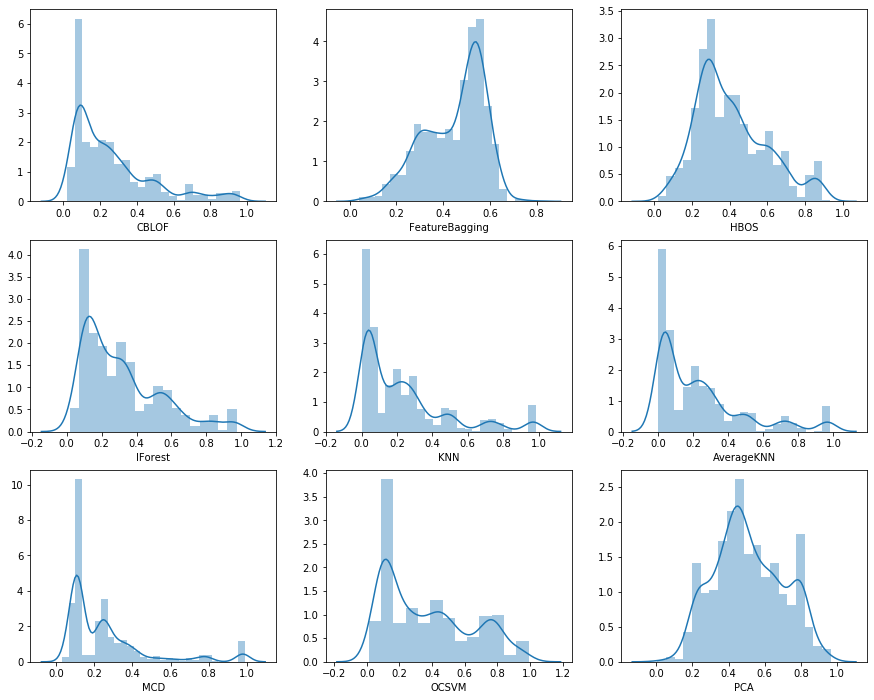

In [11]:
plt.figure(figsize=(15, 12))
i=1
for column in total_troc.columns:
    subplot = plt.subplot(3, 3, i)
    i=i+1
    sns.distplot(total_troc[column])

## 测试集的ROC结果的盒图

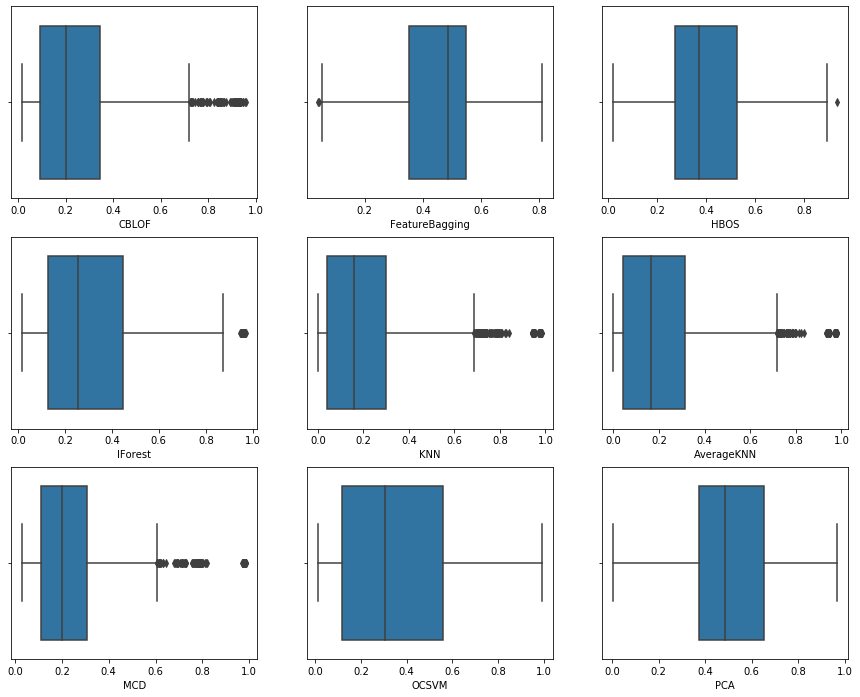

In [12]:
i=1
plt.figure(figsize=(15, 12))
for column in total_troc.columns:
    subplot = plt.subplot(3, 3, i)
    i=i+1
    sns.boxplot(total_troc[column])

## 测试集precision @ rank n的分布图

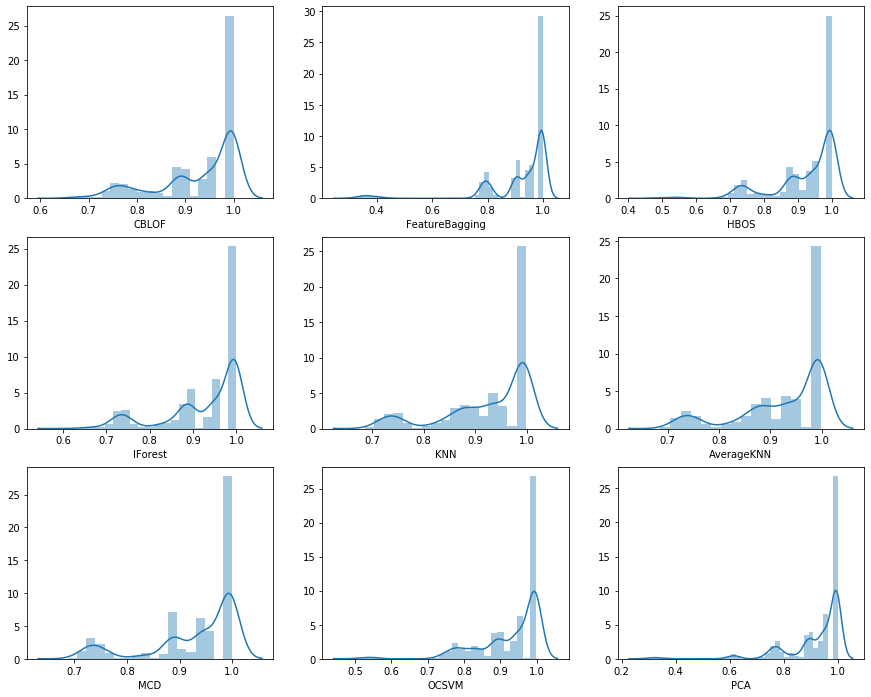

In [13]:
plt.figure(figsize=(15, 12))
i=1
for column in total_tprn.columns:
    subplot = plt.subplot(3, 3, i)
    i=i+1
    sns.distplot(total_tprn[column])

## 测试集precision @ rank n的盒图

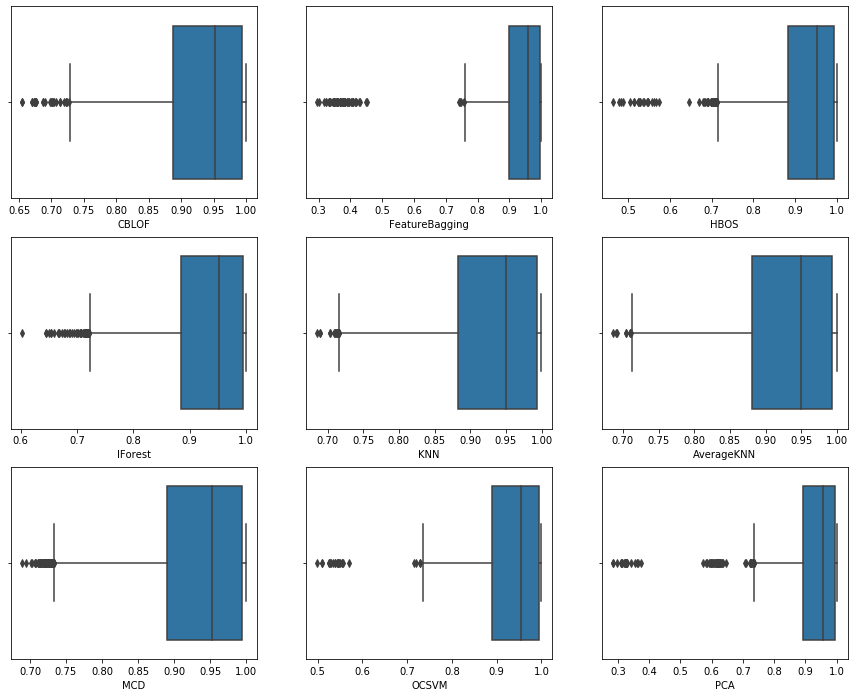

In [14]:
i=1
plt.figure(figsize=(15, 12))
for column in total_tprn.columns:
    subplot = plt.subplot(3, 3, i)
    i=i+1
    sns.boxplot(total_tprn[column])

## 由训练集和测试集的ROC和precision @ rank n指标总看出，PCA的总体效果更好。